# MAE: M-Estimator Auto-Encoder
We provide an M-estimator auto-encoder, a consistent estimator of the model parameters. Unlike a variational auto-encoder (VAE), no approximation takes place, and sampling is done on the marginal model, not from the posterior distribution.

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [160]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        batch = tf.shape(inputs)[0]
        dim = tf.shape(inputs)[1]
        return tf.keras.backend.random_normal(shape=(batch, dim))

## Build the encoder

In [161]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim)(x)
z_sim = Sampling()(z)  # This is done here so that the shape is known
encoder = keras.Model(encoder_inputs, [z, z_sim], name="encoder")
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_49 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 flatten_24 (Flatten)        (None, 3136)              0         
                                                                 
 dense_71 (Dense)            (None, 16)                50192     
                                                                 
 dense_72 (Dense)            (None, 2)                 34        
                                                                 
 sampling_21 (Sampling)      (None, 2)                 0   

## Build the decoder

In [162]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_73 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_23 (Reshape)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_69 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_70 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_71 (Conv2D  (None, 28, 28, 1)        289 

## Define the MAE

In [163]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.z_loss_tracker = keras.metrics.Mean(
            name="z_loss"
        )
        self.y_loss_tracker = keras.metrics.Mean(name="y_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.z_loss_tracker,
            self.y_loss_tracker,
        ]

    def train_step(self, data):
        # compute zhat and simulate
        z_hat, z_sim = self.encoder(data)
        # TODO: here, it should really simulate the data from the model... not simply return the average. We'll have bias that way.
        y_sim = self.decoder(z_sim)

        # Tape the gradient for z
        with tf.GradientTape() as z_tape:
            z_sim_hat, _ = self.encoder(y_sim)
            z_loss = 0.5 * tf.square(z_sim_hat - z_sim)
            z_loss = tf.reduce_mean(tf.reduce_sum(z_loss, axis=1))

        # Tape the gradient for y
        with tf.GradientTape() as y_tape:
            y_hat = self.decoder(z_hat)
            y_loss = tf.math.multiply(y_hat, data)
            y_loss = - tf.reduce_mean(tf.reduce_sum(y_loss, axis=1))

        # Tape the gradient for y_sim

        with tf.GradientTape() as y_sim_tape:
            y_sim_hat = self.decoder(z_sim_hat)
            y_sim_loss = tf.math.multiply(y_sim_hat, y_sim)
            y_sim_loss = tf.reduce_mean(tf.reduce_sum(y_sim_loss, axis=1))

        # Update the losses TODO: the loss should follow whatever model is used
        total_loss = z_loss + tf.reduce_mean(tf.reduce_sum(0.5 * tf.square(data - y_hat)))
        self.total_loss_tracker.update_state(total_loss)
        self.z_loss_tracker.update_state(z_loss)
        self.y_loss_tracker.update_state(y_loss)


        # Update the parameters for the encoder
        z_grads = z_tape.gradient(z_loss, self.encoder.trainable_weights)
        self.optimizer.apply_gradients(zip(z_grads, self.encoder.trainable_weights))


        # Update the parameters for the decoder
        y_grads = y_tape.gradient(y_loss, self.decoder.trainable_weights)
        y_sim_grads = y_sim_tape.gradient(y_sim_loss, self.decoder.trainable_weights)

        self.optimizer.apply_gradients(zip(y_grads, self.decoder.trainable_weights))
        self.optimizer.apply_gradients(zip(y_sim_grads, self.decoder.trainable_weights))
        

        return {
            "total_loss": self.total_loss_tracker.result(),
            "z_loss": self.z_loss_tracker.result(),
            "y_loss": self.y_loss_tracker.result(),
        }

## Train the Model

In [164]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = (np.expand_dims(mnist_digits, -1).astype("float32") -122)/ 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-2))
 
vae.fit(mnist_digits, epochs=2, batch_size=512)

Epoch 1/2
137/137 [==============================] - 99s 696ms/step - total_loss: 20976.5312 - z_loss: 1.0022 - y_loss: -3.0903
Epoch 2/2
 37/137 [=======>......................] - ETA: 1:43 - total_loss: 19350.4316 - z_loss: 1.0114 - y_loss: -3.3109

KeyboardInterrupt: 

1/1 [==============================] - 0s 28ms/step


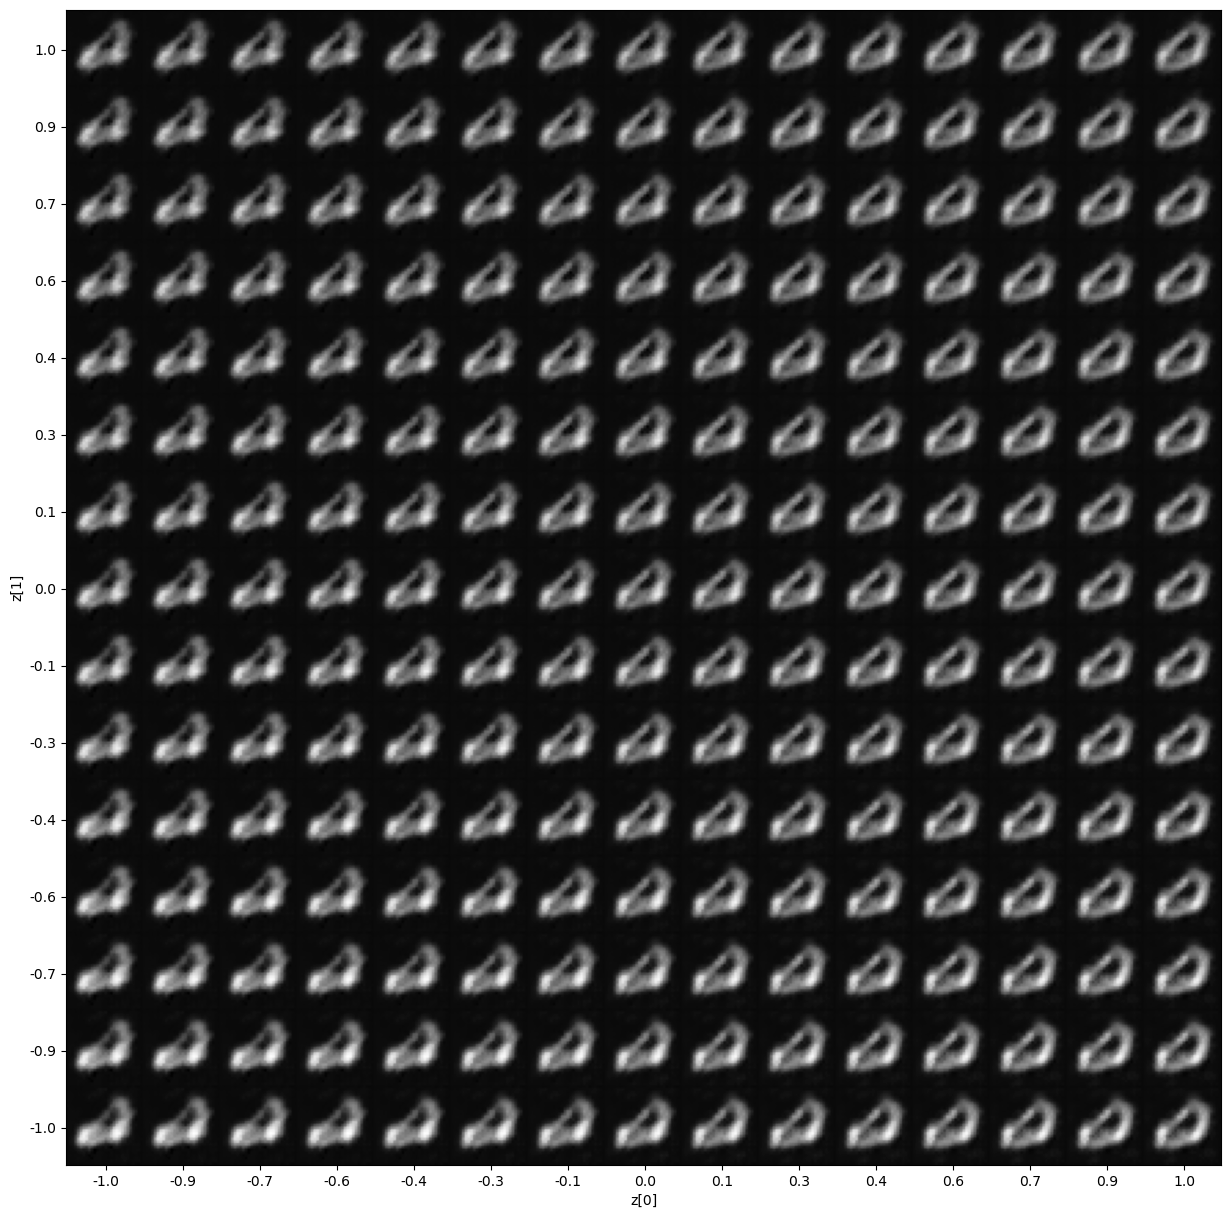

In [102]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae, n=15)